In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import datetime, timedelta

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

# Введение

Вы — аналитик интернет-магазина, работающего, в основном, с аудиторией в Европе. Продуктовые менеджеры готовятся внести изменения в onboarding-воронку для новых пользователей. Чтобы померить эффективнось новой воронки, они просят вас помочь провести АВ-тест.

Представьте, что на калентаре 1-е ноября 2020 года.

# 1. Подготовка к проведению теста

Вы еще раз все обсудили менеджерами и решили, что тест должен проводиться по вот такому сценарию:
- Тест должен затрагивать только 20% новых юзеров в вашем основном регионе (EU);
- Метрики теста:
    - Конверсия в покупку, ожидается, что она повысится минимум на 25%;
    - Средняя длительность сессии в минутах, ожидатеся, что она вырастет на 15%.
- Тест должен быть запущен не раньше 1 декабря 2020 года - отдел разработки не успевает все закончить раньше;
- Название теста `new_interface_test`;
- В тесте должны быть две группа:
    - `А` - контрольная, нет изменений; 
    - `B` - тестовая, с новой платежной воронкой. 

## 1.1 Предобработка данных

Грузим исторические данные:

In [2]:
new_users = pd.read_csv('cons_users_history.csv')
sessions = pd.read_csv('cons_sessions_history.csv')
purchases = pd.read_csv('cons_purchases_history.csv')


Изучаем данные:

In [3]:
display(new_users.head(5))
new_users.info()

,user_id,first_date,region,device
0,E302123B7000BFE4,2020-09-07,APAC,Android
1,2530F72E221829FB,2020-09-07,EU,iPhone
2,876E020A4FC512F5,2020-09-07,EU,PC
3,2640B349E1D81584,2020-09-07,EU,Android
4,94E1CBFAEF1F5EE9,2020-09-07,APAC,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     144641 non-null  object
 1   first_date  144641 non-null  object
 2   region      144641 non-null  object
 3   device      144641 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [4]:
display(sessions.head(5))
sessions.info()

,user_id,session_start,session_duration
0,72AC8300FD24B022,2020-09-01 00:29:54,1.887177
1,557FDAFEDC0F995C,2020-09-01 00:23:48,1.969538
2,BE0816B88B7650F2,2020-09-01 11:30:05,2.705548
3,806173CEAC3A1859,2020-09-01 20:15:17,6.164533
4,EDB219D52C071EC8,2020-09-01 21:26:30,5.716415


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663863 entries, 0 to 663862
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           663863 non-null  object 
 1   session_start     663863 non-null  object 
 2   session_duration  663863 non-null  float64
dtypes: float64(1), object(2)
memory usage: 15.2+ MB


In [5]:
display(purchases.head(5))
purchases.info()

,user_id,event_dt,revenue
0,72AC8300FD24B022,2020-09-01 00:29:54,4.99
1,B73A1EC68AEB1BDF,2020-09-01 09:42:59,9.99
2,4367810A6E3F8A89,2020-09-01 11:32:11,4.99
3,0FFBE1A139D092CB,2020-09-01 20:52:06,4.99
4,5EF776307EE761E7,2020-09-01 18:58:31,9.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223216 entries, 0 to 223215
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   223216 non-null  object 
 1   event_dt  223216 non-null  object 
 2   revenue   223216 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.1+ MB


Выводы:
- пропусков нет;
- даты имеет смысл привести к datetime.

In [6]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt']) 

Отбираем только новых пользователей и только из нужного региона. Плюс из календаря маркетинга отбираем только активности для нужного региона.

In [7]:
eu_new_users = new_users.query('region == "EU"')
eu_sessions = sessions.copy()[sessions['user_id'].isin(eu_new_users['user_id'])]
eu_purchases = purchases[purchases['user_id'].isin(eu_new_users['user_id'])]

## 2.1 Определение длительности теста
- Составляем список метрик и для каждой метрики задайте практическую значимость;
- Задаем уровень статистической значимости и требуемую мощность;
- Проводим коррекцию уровня значимости в соотвествии с количеством метрик;
- Расчитывыем необходимую длительность теста для кажой из метрик, выберите общую длительность теста.

In [8]:
pd.set_option('display.max_colwidth', None)
# задаем набор метрик
metrics = pd.DataFrame([
                        ['Конверсия в покупку', None, None, 0.25, None, None, None],
                        ['Средняя длительность сессии', None, None, 0.15, None, None, None],
                       ], columns = ['Метрика', 
                                     'mean', 
                                     'std', 
                                     'Относительная практическая значимость', 
                                     'Количество наблюдений',
                                     'Наблюдений в день',
                                     'Длительность']).set_index('Метрика')
metrics

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,None,None,0.25,None,None,None
Средняя длительность сессии,None,None,0.15,None,None,None


Заполняем средние и СКО по историческим данным:
- Конверсия в покупку

In [9]:
p = len(eu_purchases['user_id'].unique()) / len(eu_new_users['user_id'].unique())
metrics.loc[metrics.index == 'Конверсия в покупку', ['mean', 'std']] = [p, np.sqrt(p * (1 - p))]
metrics

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,None,None,None
Средняя длительность сессии,None,None,0.15,None,None,None


- Средняя длительность сессии

,count,mean,std,min,5%,50%,95%,max
session_duration,280623.0,5.005079,5.013423,0.00002,0.258142,3.472495,15.008576,86.071318


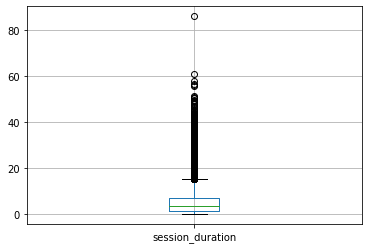

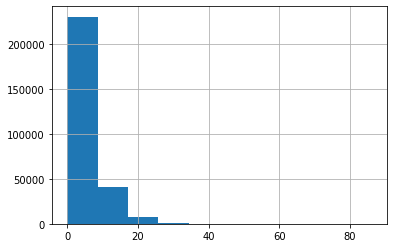

In [10]:
report = eu_sessions.copy()
display(report.describe(percentiles = [0.05, 0.5, 0.95]).T)
report.boxplot()
plt.show()
report['session_duration'].hist()
plt.show()

Выбросы есть, почистим их, а потом почситаем среднее и СКО:

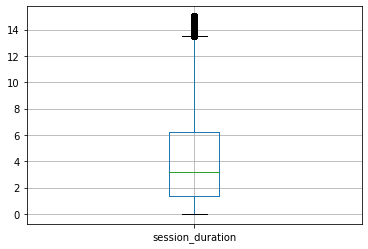

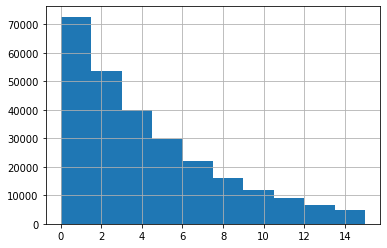

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,None,None,None
Средняя длительность сессии,4.212322,3.545341,0.15,None,None,None


In [11]:
p95 = report.describe(percentiles = [0.05, 0.5, 0.95]).T['95%']['session_duration']
report = report.query('session_duration <= @p95')

report.boxplot()
plt.show()
report['session_duration'].hist()
plt.show()

metrics.loc[metrics.index == 'Средняя длительность сессии', ['mean', 'std']] = [report['session_duration'].mean(), 
                                                                                report['session_duration'].std()]
metrics

Задаем уровень значимости и мощность, корректируем уровень значимости. Для уровня значимости и мощности берем дежурные значения, коррекцию проводим методом Бонферрони:

In [12]:
alpha = 0.05
power = 0.8
alpha = alpha / metrics.shape[0]
alpha, power

(0.025, 0.8)

Расчитываем количество наблюдений:

In [13]:
# функция для расчета длительности теста 
def get_sample_size(mean, 
                    std,                            
                    relative_practical_significance, 
                    alpha, 
                    power):
    
    z = stats.norm.ppf(1 - alpha / 2) + abs(stats.norm.ppf(1 - power))
    d = mean * relative_practical_significance
    
    return math.ceil(2 * ((std * z / d) ** 2))

metrics['Количество наблюдений'] = metrics.apply(lambda x: get_sample_size(x['mean'], 
                                                                           x['std'], 
                                                                           x['Относительная практическая значимость'],
                                                                           alpha, 
                                                                           power), axis = 1)
metrics

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,358,None,None
Средняя длительность сессии,4.212322,3.545341,0.15,599,None,None


Заполняем количество наблюдений в единицу времени (день):
- Для конверсии в покупку наблюдение это каждый новый пользователь;
- Для длительности сессий наблюдение это одна сессия. Т.к. один пользователь сгенерирует как минимум одну сессию, можем считать, что количество наблюдений в день равно как минимум числу новых пользователей в день.

При расчете учитываем, что в тест будут попадать только 20% новых пользователей.

In [14]:
test_audience_percent = 0.2

# конверсия в покупку
mean_daily_users = eu_new_users.groupby('first_date').agg({'user_id': 'nunique'})['user_id'].mean()
metrics.loc[metrics.index == 'Конверсия в покупку', 'Наблюдений в день'] = mean_daily_users * test_audience_percent

# средняя длительность сессии
metrics.loc[metrics.index == 'Средняя длительность сессии', 'Наблюдений в день'] = mean_daily_users * test_audience_percent

metrics['Наблюдений в день'] = metrics['Наблюдений в день'].astype(int)

metrics  

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,358,241,None
Средняя длительность сессии,4.212322,3.545341,0.15,599,241,None


Расчитаем длительности тестов, учитывая количество групп в тесте:

In [15]:
test_groups_num = 2
metrics['Длительность'] = np.ceil(metrics['Количество наблюдений'] / metrics['Наблюдений в день'] * test_groups_num).astype(int)
display(metrics)

test_duration = metrics['Длительность'].max()
print('Рекомендованная длительность теста: {} дня(ей)'.format(test_duration))

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,358,241,3
Средняя длительность сессии,4.212322,3.545341,0.15,599,241,5


Рекомендованная длительность теста: 5 дня(ей)


Проверим, демонстрируют ли данные сезонность:

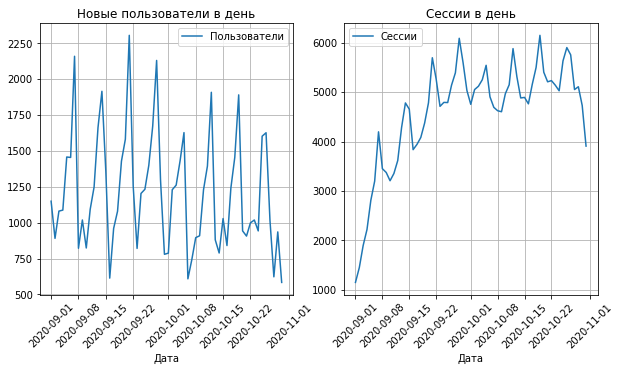

In [16]:
plt.subplots(figsize = (10, 5))

report = eu_new_users.copy()
report['first_date'] = report['first_date'].dt.date
(report.groupby('first_date').agg({'user_id': 'nunique'})
       .rename(columns = {'user_id': 'Пользователи'})
       .plot(ax = plt.subplot(1, 2, 1), grid = True))
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Новые пользователи в день')

report = eu_sessions.copy()
report['session_start'] = report['session_start'].dt.date
(report.groupby('session_start').agg({'user_id': 'count'})
       .rename(columns = {'user_id': 'Сессии'})
       .plot(ax = plt.subplot(1, 2, 2), grid = True))
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.title('Сессии в день')

plt.show()

Вывод: данные демонстрируют явную недельную сезонность. 

Имеет смысл установить длительность теста кратной одной недели. Расчитаем длительность теста с учетом недельной сезонности.

In [17]:
test_duration_adjusted = int(np.ceil(test_duration / 7) * 7)
print('Рекомендованная длительность теста (с учетом недельной сезонности): {} дня(ей)'.format(test_duration_adjusted))

Рекомендованная длительность теста (с учетом недельной сезонности): 7 дня(ей)


Вывод: тест должен быть не короче 7 дней для того, чтобы набрать нужное количество пользователей. 

## 1.3 Определение момента запуска и остановки теста

Заказчик просит запустить тест не ранее 01.12, нужно отследить все акции.

## 1.4 Составление технического задания для разработчиков

Параметры теста:
- Наименование теста: new_interface_test;
- Группы: А (котрольная), B (новая платежная воронка);
- Дата запуска: 2021-01-04
- Дата остановки набора новых пользователей: 2021-01-10;
- Дата остановки: 2021-01-16 (+7 дней активности);
- Аудитория: 20% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной onboarding-воронки;
- Ожидаемый эфект: конверсия в покупку изменится на 25%, средняя длительность сессии изменится на 15%.

Задаем временные границы теста:

In [18]:
test_start = pd.to_datetime('2021-01-04')
user_acquisition_duration = 7
activity_duration = 1
user_acquisition_end = test_start + timedelta(user_acquisition_duration - 1)

# 2. Проведение теста: ситуация через 5 дней после запуска

После долгих размышлений тест все же решили запустить 4-го января 2021 года. Представьте, что сейчас на календаре 5й день теста - 8-е января 2021. Вам нужно проанализировать промежуточные результаты теста и принять решение о его остановке или продолжении.

## 2.1 Загрузка и подготовка данных

Загружаем данные, преобразуем даты и время:

In [19]:
new_users = pd.read_csv('cons_new_users_monitoring.csv')
sessions = pd.read_csv('cons_sessions_monitoring.csv')
purchases = pd.read_csv('cons_purchases_monitoring.csv')
test_participants = pd.read_csv('cons_participants_monitoring.csv')

new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start']).dt.date
purchases['event_dt'] = pd.to_datetime(purchases['event_dt']).dt.date

Посмотрим, как у нас обстоят дела с участниками теста:

In [20]:
test_participants

,user_id,group,ab_test
0,0560881DCDCCB068,B,new_interface_test
1,CD3F1B78180A4F01,A,new_interface_test
2,03096D6895415472,A,new_interface_test
3,A0440113C7188632,A,new_interface_test
4,AA750EC1FEF2FD88,A,new_interface_test
...,...,...,...
1367,65AEDB98F1635C55,A,another_test
1368,87FE590820DA3100,A,another_test
1369,B20303AB90C874AE,B,another_test
1370,D72A72121175D8BE,B,another_test


In [21]:
test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test            group         
another_test       A           33
                   B           32
new_interface_test A          695
                   B          612

Кроме нашего теста, оказывается был еще параллельный тест another_test. Посмотрим, насколько пересеклись их аудитории:

In [22]:
test_participants.groupby('user_id').agg({'ab_test': 'nunique'}).sort_values(by = 'ab_test', ascending = False).head(3)

,ab_test
user_id,
10B478AFB18AFF23,2
0001710F4DDB1D1B,1
AA1B82640E331B47,1


Всего один пользователь угодил сразу в два теста. Просто отфильтруем another_test.

In [23]:
test_participants = test_participants.query('ab_test == "new_interface_test"')

В остальных данных уберем все, что не касается участников теста:

In [24]:
test_new_users = new_users[new_users['user_id'].isin(test_participants['user_id'])].merge(test_participants, on = 'user_id')
test_sessions = sessions[sessions['user_id'].isin(test_participants['user_id'])].merge(test_participants, on = 'user_id')
test_purchases = purchases[purchases['user_id'].isin(test_participants['user_id'])].merge(test_participants, on = 'user_id')

In [25]:
test_new_users.head(5)

,user_id,first_date,region,device,group,ab_test
0,FFCEA1179C253104,2021-01-04,EU,PC,B,new_interface_test
1,0FC21E6F8FAA8DEC,2021-01-04,EU,Android,A,new_interface_test
2,7713F4DD96975E70,2021-01-04,EU,Android,B,new_interface_test
3,5DFA5DCA1EAB4A61,2021-01-04,EU,PC,B,new_interface_test
4,26D11E1624C22789,2021-01-04,EU,PC,A,new_interface_test


## 2.2 Проверка корректности проведения теста

Посмотрим на состав участников теста по регионам:

In [26]:
report = test_new_users.groupby('region').agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'Участники'})
report['% участников'] = (report['Участники'] / report['Участники'].sum()).round(2)
report.sort_values(by = 'Участники', ascending = False)

,Участники,% участников
region,,
EU,1231,0.94
CIS,44,0.03
APAC,18,0.01
N.America,14,0.01


Основная масса участников была из нужного региона, все ок. Небольшое количество учатников из других регионов можно объяснить перелетами, использованием VPN и т.д.

Проверим, составили ли участники теста нужный % от общего числа новых пользователей в регионе (возьмем только пользователей, пришедших во время теста):

In [27]:
eu_test_users = test_new_users.query('region == "EU"').shape[0]
eu_users = new_users.query('region == "EU" and first_date >= @test_start and first_date <= @user_acquisition_end').shape[0]
eu_test_users / eu_users

0.19980522642428178

Чуть выше уровня, который закладывался в техническом задании. Это нормально. Проведем тест, чтобы проверить действительно ли это статистически значимое различие:
- H0: для пользователя из региона EU вероятность попасть в тест составляет 20%;
- H1: для пользователя из региона EU вероятность попасть в тест отличается от 20%.

Уровень значимости установим 0.05 и откорректируем методом Бонферрони т.к. мы проводим в этой части два теста - текущий и тест на распрееление пользователей по группам.

In [28]:
alpha = 0.05
alpha = alpha / 2
pvalue = proportions_ztest(eu_test_users, eu_users, value = 0.2)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: для пользователя из региона EU вероятность попасть в тест составляет 20%.')
else:
    print('Нулевая гипотеза отвергается: для пользователя из региона EU вероятность попасть в тест отличается от 20%.')

p-value: 0.969500787738556
Нулевая гипотеза не отвергается: для пользователя из региона EU вероятность попасть в тест составляет 20%.


Теперь проверим, была ли вероятность попасть в группы одинаковой:

In [29]:
a_users = test_new_users.query('group == "A"').shape[0]
all_participants = test_new_users.shape[0]
a_users / all_participants

0.531752104055088

Вероятность попасть в группу А составила 53%. Проверим одновыборочным z-тестом:
- H0: вероятность попасть в группу А составляет 50%;
- H1: веростность попасть в группу А отличается от 50%

In [30]:
alpha = 0.05
alpha = alpha / 2
pvalue = proportions_ztest(a_users, all_participants, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 0.021421246374848806
Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%


Отлично, значит нам показалось и вероятность попасть в каждую группу равна 50%.

## 2.3 Анализ накопительных метрик и принятие решения об остановке

Установим уровень для необходимого минимального числа участников теста.

In [31]:
metrics

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,358,241,3
Средняя длительность сессии,4.212322,3.545341,0.15,599,241,5


Для необходимого минимального числа участников теста мы берем потребное количество наблюдений для метрики "Средняя длительность сессии" т.к. именно она влиятет на длительность проведения теста.

In [32]:
required_participants = metrics.loc['Средняя длительность сессии', 'Количество наблюдений'] * test_groups_num
required_participants

1198

Кумулятивная динамика:

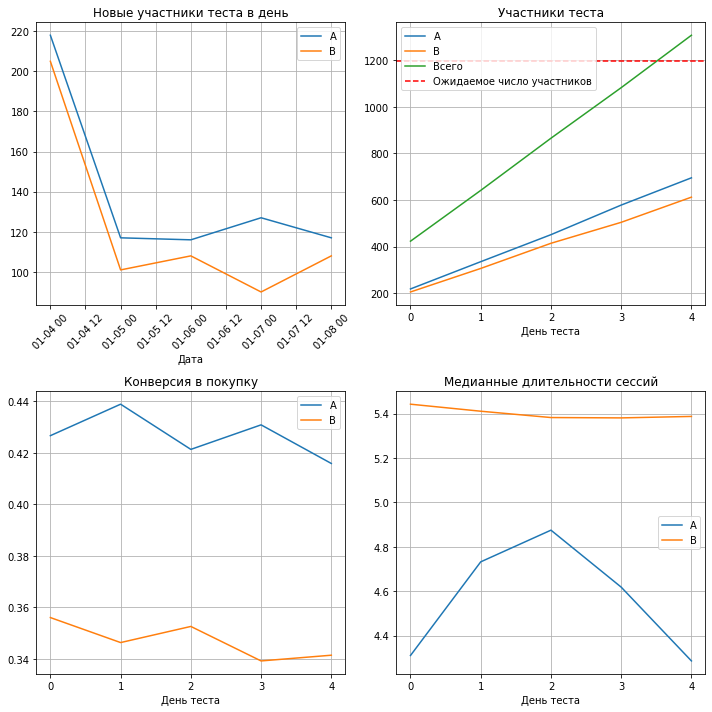

In [33]:
current_aquisition_duration = 5
test_dates = pd.date_range(start = test_start, periods = current_aquisition_duration)

plt.subplots(figsize = (15, 10))

cumulative_test_users = pd.DataFrame(columns = ['A', 'B'])
cumulative_test_payers = pd.DataFrame(columns = ['A', 'B'])
cumulative_test_sessions = pd.DataFrame(columns = ['A', 'B'])

for i, dt in enumerate(test_dates):

    #участники теста
    current_test_users = test_new_users.query('first_date <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_test_users['date'] = dt
    current_test_users['test_day'] = i
    cumulative_test_users = cumulative_test_users.append(current_test_users, sort = False)
    
    #платящие участники теста
    current_test_purchases = test_purchases.query('event_dt <= @dt').groupby('user_id').agg({'revenue': 'sum'})
    current_test_payers = (test_new_users.merge(current_test_purchases, on = 'user_id', how = 'inner')
                                         .query('first_date <= @dt')
                                         .groupby('group').agg({'user_id': 'nunique'}).T)
    current_test_payers['date'] = dt
    current_test_payers['test_day'] = i
    cumulative_test_payers = cumulative_test_payers.append(current_test_payers, sort = False)
    
    #длительность сессий
    current_test_sessions = test_sessions.query('session_start <= @dt').groupby('group').agg({'session_duration': 'median'}).T
    current_test_sessions['date'] = dt
    current_test_sessions['test_day'] = i
    cumulative_test_sessions = cumulative_test_sessions.append(current_test_sessions, sort = False)
    
#новые участники теста без накопления
pd.pivot_table(test_new_users, 
               index = 'first_date', 
               columns = 'group', 
               values = 'user_id', 
               aggfunc = 'count').plot(ax = plt.subplot(2, 3, 1), grid = True)
plt.title('Новые участники теста в день')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.legend()

#участники теста
cumulative_test_users = cumulative_test_users.query('date >= @test_start and date <= @user_acquisition_end').set_index('test_day')[['A', 'B']]
cumulative_test_users['Всего'] = cumulative_test_users['A'] + cumulative_test_users['B']
cumulative_test_users.plot(ax = plt.subplot(2, 3, 2), grid = True, xticks = cumulative_test_users.index)
plt.axhline(y = required_participants, label = 'Ожидаемое число участников', color = 'red', linestyle = '--')
plt.title('Участники теста')
plt.legend()
plt.xlabel('День теста')

#конверсии 
cumulative_test_payers = cumulative_test_payers.query('date >= @test_start and date <= @user_acquisition_end').set_index('test_day')[['A', 'B']]
cumulative_test_payers.div(cumulative_test_users)[['A', 'B']].fillna(0).plot(ax = plt.subplot(2, 3, 4), grid = True, xticks = cumulative_test_users.index)
plt.title('Конверсия в покупку')
plt.legend()
plt.xlabel('День теста')

#длительности сессий
cumulative_test_sessions = cumulative_test_sessions.query('date >= @test_start and date <= @user_acquisition_end').set_index('test_day')[['A', 'B']]
cumulative_test_sessions.plot(ax = plt.subplot(2, 3, 5), grid = True, xticks = cumulative_test_users.index)
plt.title('Медианные длительности сессий')
plt.legend()
plt.xlabel('День теста')

plt.tight_layout()
plt.show()

Выводы и наблюдения:
- Кумулятивные метрики практически достигли стабильности, но лучше посмотреть еще пару дней;
- Необходимое количество пользователей едва набрано;
- Набор новых пользователей останавливать, тем не менее, не будем т.к. впереди уикенд, который может повлиять на результаты по конверсии;
- Сам тесте останавливать не будет т.к. нам нужно для каждого пользователя получить хотя бы неделю активности после первого захода на сайт.

# 3. Анализ результатов теста

На календаре 17 января 2020 года, тест завершен. Вам нужно проанализировать его результаты.

## 3.1 Подготовка данных

Загружаем данные, преобразуем даты и веремя:

In [34]:
new_users = pd.read_csv('cons_users_test.csv')
sessions = pd.read_csv('cons_sessions_test.csv')
purchases = pd.read_csv('cons_purchases_test.csv')
test_participants = pd.read_csv('cons_participants_test.csv')

new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start']).dt.date
purchases['event_dt'] = pd.to_datetime(purchases['event_dt']).dt.date

Посмотрим, как у нас обстоят дела с участниками теста:

In [35]:
test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test            group         
another_test       A           43
                   B           47
new_interface_test A         1022
                   B          919

Отфильтруем new_login_screen_apac.

In [36]:
test_participants = test_participants.query('ab_test == "new_interface_test"')

В остальных данных уберем все, что не касается участников теста:

In [37]:
test_new_users = new_users[new_users['user_id'].isin(test_participants['user_id'])].merge(test_participants, on = 'user_id')
test_sessions = sessions[sessions['user_id'].isin(test_participants['user_id'])].merge(test_participants, on = 'user_id')
test_purchases = purchases[purchases['user_id'].isin(test_participants['user_id'])].merge(test_participants, on = 'user_id')

## 3.2 Анализ накопительных метрик 

Установим уровень для необходимого минимального числа участников теста.

In [38]:
metrics

,mean,std,Относительная практическая значимость,Количество наблюдений,Наблюдений в день,Длительность
Метрика,,,,,,
Конверсия в покупку,0.459969,0.498395,0.25,358,241,3
Средняя длительность сессии,4.212322,3.545341,0.15,599,241,5


In [39]:
required_participants = metrics.loc['Средняя длительность сессии', 'Количество наблюдений'] * test_groups_num

Кумулятивная динамика:

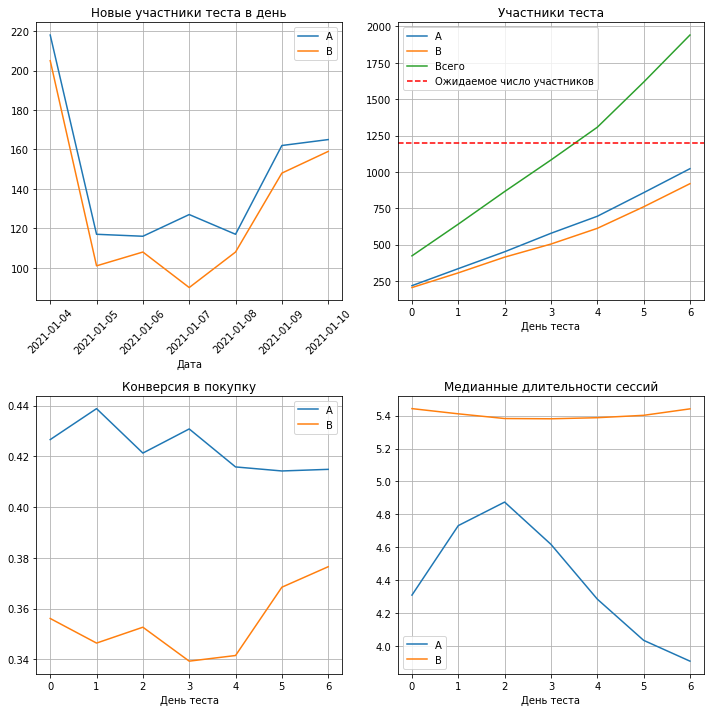

In [40]:
current_aquisition_duration = 7
test_dates = pd.date_range(start = test_start, periods = current_aquisition_duration)

plt.subplots(figsize = (15, 10))

cumulative_test_users = pd.DataFrame(columns = ['A', 'B'])
cumulative_test_payers = pd.DataFrame(columns = ['A', 'B'])
cumulative_test_sessions = pd.DataFrame(columns = ['A', 'B'])

for i, dt in enumerate(test_dates):

    #участники теста
    current_test_users = test_new_users.query('first_date <= @dt').groupby('group').agg({'user_id': 'nunique'}).T
    current_test_users['date'] = dt
    current_test_users['test_day'] = i
    cumulative_test_users = cumulative_test_users.append(current_test_users, sort = False)
    
    #платящие участники теста
    current_test_purchases = test_purchases.query('event_dt <= @dt').groupby('user_id').agg({'revenue': 'sum'})
    current_test_payers = (test_new_users.merge(current_test_purchases, on = 'user_id', how = 'inner')
                                         .query('first_date <= @dt')
                                         .groupby('group').agg({'user_id': 'nunique'}).T)
    current_test_payers['date'] = dt
    current_test_payers['test_day'] = i
    cumulative_test_payers = cumulative_test_payers.append(current_test_payers, sort = False)
    
    #длительность сессий
    current_test_sessions = test_sessions.query('session_start <= @dt').groupby('group').agg({'session_duration': 'median'}).T
    current_test_sessions['date'] = dt
    current_test_sessions['test_day'] = i
    cumulative_test_sessions = cumulative_test_sessions.append(current_test_sessions, sort = False)
    
#новые участники теста без накопления
pd.pivot_table(test_new_users, 
               index = 'first_date', 
               columns = 'group', 
               values = 'user_id', 
               aggfunc = 'count').plot(ax = plt.subplot(2, 3, 1), grid = True)
plt.title('Новые участники теста в день')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.legend()

#участники теста
cumulative_test_users = cumulative_test_users.query('date >= @test_start and date <= @user_acquisition_end').set_index('test_day')[['A', 'B']]
cumulative_test_users['Всего'] = cumulative_test_users['A'] + cumulative_test_users['B']
cumulative_test_users.plot(ax = plt.subplot(2, 3, 2), grid = True, xticks = cumulative_test_users.index)
plt.axhline(y = required_participants, label = 'Ожидаемое число участников', color = 'red', linestyle = '--')
plt.title('Участники теста')
plt.legend()
plt.xlabel('День теста')

#конверсии 
cumulative_test_payers = cumulative_test_payers.query('date >= @test_start and date <= @user_acquisition_end').set_index('test_day')[['A', 'B']]
cumulative_test_payers.div(cumulative_test_users)[['A', 'B']].fillna(0).plot(ax = plt.subplot(2, 3, 4), grid = True, xticks = cumulative_test_users.index)
plt.title('Конверсия в покупку')
plt.legend()
plt.xlabel('День теста')

#длительности сессий
cumulative_test_sessions = cumulative_test_sessions.query('date >= @test_start and date <= @user_acquisition_end').set_index('test_day')[['A', 'B']]
cumulative_test_sessions.plot(ax = plt.subplot(2, 3, 5), grid = True, xticks = cumulative_test_users.index)
plt.title('Медианные длительности сессий')
plt.legend()
plt.xlabel('День теста')

plt.tight_layout()
plt.show()

Выводы и наблюдения:
- Накопительные метрики достигли относительной стабильности по обеим группам;
- По конверсии, визуально, выиграла группа А;
- По длительности сессии, похоже, выиграла группа В;
- Нужные количества наблюдений достигнуты практически по всем метрикам еще на 5-й день, так что у нас достаточно данных для проведения тестов. 

## 4.3 Проверка гипотез

Будем проводить три теста:
- Процент конвертации в покупку проведем с помощью двухвыборочного z-теста т.к. здесь мы имеем дело с вероятностью конверсии (пропорцией);
- Средняя длительность сессии проверим t-тестом и тестом Манна-Уитни (просто чтобы иметь возможность сравнить результаты).

Поскольку тестов (и гипотез) у нас три, приведем коррекцию уровня значимости методом Бонферрони:

In [41]:
alpha = 0.05
alpha = alpha / 3
alpha

0.016666666666666666

Процент конвертации в покупку:

In [42]:
report = test_participants.merge(test_purchases.groupby('user_id').agg({'revenue': 'sum'}), on = 'user_id', how = 'left')
report['is_buyer'] = (report['revenue'] > 0).astype(int)
report = (report.groupby('group').agg({'user_id': 'count', 'is_buyer': 'sum'})
                                 .rename(columns = {'user_id': 'Участники', 'is_buyer': 'Покупатели'}))
report['Конверсия'] = (report['Покупатели'] / report['Участники']).round(2)
report

,Участники,Покупатели,Конверсия
group,,,
A,1022,424,0.41
B,919,346,0.38


Похоже, что конверсия в группе В сильно ниже. Проверим есть ли отличие с помощью стат-теста:
- H0: Между группами A и B нет различий в % конверсии в покупку;
- H1: Между группами A и B есть различие % конверсии в покупку.

In [43]:
count = list(report['Покупатели'].values)
nobs = list(report['Участники'].values)

pvalue = proportions_ztest(count, nobs, value = 0)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в покупку.')
else:
    print('Нулевая гипотеза отвергается: между группами A и B есть различие % конверсии в покупку.')

p-value: 0.08442039873710082
Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в покупку.


Средняя длительность сессии:

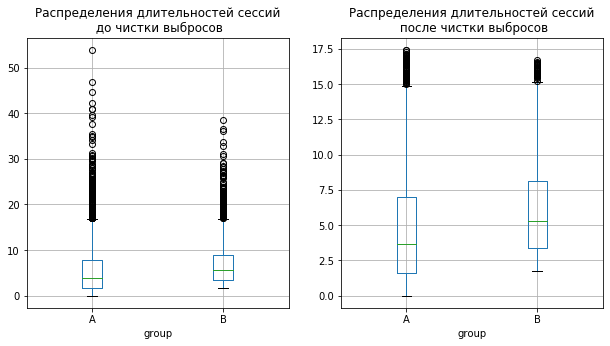

In [44]:
report = test_sessions.copy()

plt.subplots(figsize = (10, 5))
report.boxplot('session_duration', by = 'group', ax = plt.subplot(1, 2, 1))
plt.title('Распределения длительностей сессий\n до чистки выбросов')

a_sessions = report.query('group == "A"')[['session_duration', 'group']]
b_sessions = report.query('group == "B"')[['session_duration', 'group']]

#чистим выбросы
a_sessions = a_sessions[a_sessions['session_duration'] < a_sessions['session_duration'].quantile(0.95)]
b_sessions = b_sessions[b_sessions['session_duration'] < b_sessions['session_duration'].quantile(0.95)]
a_sessions.append(b_sessions).boxplot('session_duration', by = 'group', ax = plt.subplot(1, 2, 2))
plt.suptitle('')
plt.title('Распределения длительностей сессий\n после чистки выбросов')
plt.show()

Видно, что средняя длительность сессий в группе В заметно подросла. Проверим это t-тестом:
- H0: медианная длительность сессий в группах А и В одинаковая;
- H1: медианная длительность сессий в группах А и В отличается;

In [45]:
pvalue = stats.ttest_ind(a_sessions['session_duration'].values, b_sessions['session_duration'].values).pvalue

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: средняя длительность сессий в группах А и В одинаковая.')
else:
    print('Нулевая гипотеза отвергается: средняя длительность сессий в группах А и В отличается.')
    
delta = b_sessions['session_duration'].mean() - a_sessions['session_duration'].mean()
b_sessions['session_duration'].mean(), a_sessions['session_duration'].mean(), delta, (b_sessions['session_duration'].mean() - 4.21) / 4.21

p-value: 8.704016848124417e-33
Нулевая гипотеза отвергается: средняя длительность сессий в группах А и В отличается.


(6.1545013416423595,
 4.854308241159301,
 1.3001931004830585,
 0.46187680324046543)

Разница между группами составляет примерно 1.3 минуты в пользу группы В.

Продублируем тестом Манна-Уитни, без чистки выбросов:

In [46]:
a_sessions = report.query('group == "A"')[['session_duration', 'group']]
b_sessions = report.query('group == "B"')[['session_duration', 'group']]

pvalue = stats.mannwhitneyu(a_sessions['session_duration'].values, 
                            b_sessions['session_duration'].values, alternative ='two-sided' )[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: медианная длительность сессий в группах А и В одинаковая.')
else:
    print('Нулевая гипотеза отвергается: медианная длительность сессий в группах А и В отличается.')
     
b_sessions['session_duration'].median(), a_sessions['session_duration'].median(), b_sessions['session_duration'].median() - a_sessions['session_duration'].median()

p-value: 2.298513910588821e-54
Нулевая гипотеза отвергается: медианная длительность сессий в группах А и В отличается.


(5.50858544202298, 3.9575410318479314, 1.5510444101750487)

Можно заключить, что средняя длительность сессии в тестовой группе выросла на 46% по сравнению с базовой длительностью (4.21 минуты).

## Выводы

Выводы:
1. Тест был проведен в соответствии с ТЗ с небольшими, практически незначимыми отклонениями;
2. Между группами наблюдаются статистически и практически значимое различие в длительности сессий - она выросла на 46% по сравнению с бейзлайном:
3. По конверсии статистически значимых отличий не обнаружилось.
    
Рекомендации для заказчика:
- Новая onboarding-воронка работает не хуже старой, пользователи проводят на сайте больше времени, конверсия не задета. Рекоммендуем внедрять ее на всех пользователей.